# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
from matplotlib import colors
import random
import plotly.io as pio

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_comunidades = "../../../reports/reports_nohubs/analisis_comunidades/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

G = nx.read_gml(graph_data+"nohub_disease_layer.gml", destringizer=int)
enfermedades = graph_node_data[(graph_node_data.node_type == "disease")|(graph_node_data.node_type == "bert_group")]

,Número de nodos
bert_group,1040
complex,421
disease,15039
gene_protein,17322
pathway,2017
total,35839


,Número de enlaces
disease_disease,16433.0
form_complex,1885.0
gda,84014.0
pathway_protein,42643.0
ppi,110051.0
total,255026.0


# Cartographic Role - Infomap

## Within-module degree:

Para cada nodo $i$, perteneciente a una comunidad $s_{i}$, calculo el "grado interno" $z_i$:

$ z_{i} = \frac{k_{i} - \bar{k}_{s_i}}{\sigma_{k_{si}}}$

Donde $k_i$ es el número de enlaces de $i$ a otros nodos de su comunidad, $\bar{k}_{s_i}$ es el promedio de $k$ sobre todos los nodos de la comunidad y $\sigma_{k_{si}}$ el desvío estandar de $k$ en $s_i$.


In [4]:
comunidades_infomap = enfermedades.comunidades_infomap.dropna().astype("int").sort_values().unique()
comunidades_louvain = enfermedades.comunidades_louvain.dropna().astype("int").sort_values().unique()

In [60]:
grafos_comunidades = {}

for comunidad in comunidades_infomap:
    nodos = graph_node_data.loc[graph_node_data.comunidades_infomap == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [61]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [62]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_18278/3316443242.py:8: RuntimeWarning:

invalid value encountered in double_scalars



Dejo los nan afuera del análisis porque salen de comunidades con sigma=0. Son comunidades chiquitas de 2 nodos que no tiene mucho sentido analizar por ahí.

## Participation coefficient

$P_i = 1 - \sum_{s=1}^{N_M} (\frac{k_{i_s}}{k_i})^2$

Donde $k_{i_s}$ es el número de enlaces del nodo i a nodos del módulo s (sumo sobre todos los módulos) y ${k_i}$ es el grado **total** del nodo i.

In [63]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_infomap"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

## Roles cartográficos

Para cada nodo (solo los BERTs) calculo la región Rn (n = [1,7]) según sus valores de z y p, como dice el paper. Al final de todo hago un gráfico con las regiones (quizás mostrando algunos nodos)

In [64]:
def cartographic_role(z,p):
    #nodos non-hub
    if z < 2.5:
        if p <= 0.05:
            role = 1
        elif p <= 0.62:
            role = 2
        elif p <= 0.8:
            role = 3
        else:
            role = 4

    #nodos hub
    else:
        if p <= 0.3:
            role = 5
        elif p<= 0.75:
            role = 6
        else:
            role = 7
            
    return role

In [65]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [66]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [67]:
role_names = {1:"ultra-peripheral", 2:"peripheral",3:"non-hub connector",4:"non-hub kinless",5:"provincial hub",6:"connector hub",7:"kinless hub"}
results_df["role_name"] = results_df.role.apply(lambda x: role_names[x])
color_discrete_map = {name:px.colors.qualitative.G10[i] for i,name in role_names.items()}

In [68]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
non_berts = graph_node_data.loc[graph_node_data.node_type == "disease", "node_index"].values
bert_roles = results_df.loc[berts].sort_values(by="role").reset_index()
non_bert_roles = results_df.loc[results_df.index.intersection(non_berts)].sort_values(by="role").reset_index()

Text(0.5, 1.0, 'Rol cartográfico - Infomap')

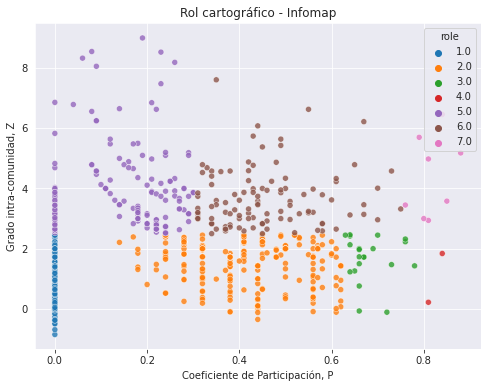

In [18]:
fig,ax = plt.subplots(figsize=(8,6))

joint = sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)

ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")
ax.set_title("Rol cartográfico - Infomap")
# fig.savefig(reports_comunidades+"scatter_rol_cartografico_infomap.png",dpi=200)

In [69]:
fig = px.scatter(bert_roles, x="participation_coefficient", y="intra_degree",text="index", width=1000, height=600, color="role_name", marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico grupos BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Participation Coefficient - P", yaxis_title="Within-module degree - Z")

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_infomap_interactivo.html")

Analizar ejemplos de Berts conectores

In [33]:
ejemplo = 1926
graph_node_data[graph_node_data.node_index == ejemplo]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
6425,1926,12123_54559_8909_26765_14904_11291_26729_30043...,congenital disorder of glycosylation,bert_group,primekg,72.0,19.0,0.0,0.0,63.0


In [37]:
comunidad = graph_node_data.loc[graph_node_data.node_index == ejemplo, "comunidades_infomap"].values[0]
graph_node_data[graph_node_data.comunidades_infomap == comunidad]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
3927,27225,C1832736,"CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Id",disease,disgenet,72.0,19.0,1.0,0.0,1.0
6425,1926,12123_54559_8909_26765_14904_11291_26729_30043...,congenital disorder of glycosylation,bert_group,primekg,72.0,19.0,0.0,0.0,63.0
6728,30656,C3150876,COG5 congenital disorder of glycosylation,disease,disgenet,72.0,19.0,1.0,0.0,1.0
7520,33272,C4317224,Congenital disorder of glycosylation type 1q,disease,disgenet,72.0,19.0,8.0,0.0,1.0
7522,23504,C0282577,Congenital Disorders of Glycosylation,disease,disgenet,72.0,19.0,10.0,0.0,1.0
7523,29408,C1970344,"Congenital Disorder Of Glycosylation, Type IIF",disease,disgenet,72.0,19.0,1.0,0.0,1.0
12769,33149,C4310727,"CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Iaa",disease,disgenet,72.0,19.0,1.0,0.0,1.0
13603,30967,C3278404,"MULTIPLE JOINT DISLOCATIONS, SHORT STATURE, AN...",disease,disgenet,72.0,19.0,2.0,0.0,2.0
13604,31460,C3553571,Carbohydrate deficient glycoprotein syndrome t...,disease,disgenet,72.0,19.0,1.0,0.0,1.0
13605,30263,C2931011,"Congenital disorder of glycosylation, type 2G",disease,disgenet,72.0,19.0,1.0,0.0,2.0


In [40]:
graph_node_data.set_index("node_index").loc[list(G.neighbors(ejemplo))]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
28052,C1848392,Zunich neuroectodermal syndrome,disease,disgenet,66.0,19.0,1.0,0.0,3.0
20104,C0025521,Inborn Errors of Metabolism,disease,disgenet,271.0,39.0,17.0,0.0,67.0
1511,11335_7738,spondyloepimetaphyseal dysplasia with joint di...,bert_group,primekg,272.0,44.0,0.0,0.0,5.0
27225,C1832736,"CONGENITAL DISORDER OF GLYCOSYLATION, TYPE Id",disease,disgenet,72.0,19.0,1.0,0.0,1.0
18752,C0005940,Bone Diseases,disease,disgenet,273.0,40.0,10.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...
30381,C2931649,"Larsen syndrome, recessive type",disease,disgenet,72.0,19.0,1.0,0.0,2.0
29025,C1865145,Congenital disorder of glycosylation type 1B,disease,disgenet,247.0,50.0,1.0,0.0,2.0
14500,7293_13016_9953_17570,leukocyte adhesion deficiency,bert_group,primekg,285.0,30.0,0.0,0.0,7.0


In [70]:
fig = px.scatter(non_bert_roles, x="participation_coefficient", y="intra_degree", width=1000, height=600, color="role_name",text="index",marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico nodos no-BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Participation Coefficient - P", yaxis_title="Within-module degree - Z")

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_no_berts_infomap_interactivo.html")

In [26]:
graph_node_data[graph_node_data.node_index == 24773]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
7836,24773,C0520572,Enzymopathy,disease,disgenet,349.0,32.0,11.0,0.0,66.0


Los nodos BERT tienen un rol conector dentro de sus comunidades, pero además tienen participación no nula, entonces conectan módulos entre sí. 

Se observan pocos valores negativos: los bert tienden a tener grado mayor a la media del módulo (recordar que el eje y está estandarizado)

In [27]:
fig = px.histogram(bert_roles, x="role", width=800, height=600, color="role_name", title="Rol cartográfico nodos BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Rol Cartográfico", yaxis_title="Count")
fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_infomap_barras_interactivo.html")

In [28]:
fig = px.histogram(non_bert_roles, x="role", width=800, height=600, color="role_name", title="Rol cartográfico nodos no-BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Rol Cartográfico", yaxis_title="Count")
fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_no_berts_infomap_barras_interactivo.html")

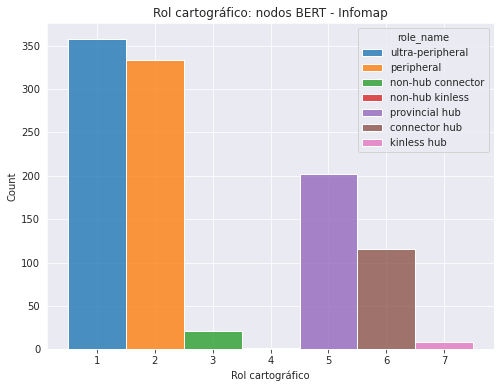

In [71]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos BERT - Infomap")
sns.histplot(data=bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap.png",dpi=200)

Para este grafico sacar los berts 

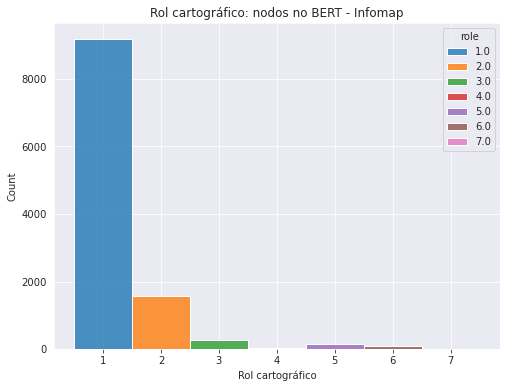

In [72]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=non_bert_roles, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_title("Rol cartográfico: nodos no BERT - Infomap")
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap_no_berts.png",dpi=200)

# Cartographic Role - Louvain

In [73]:
grafos_comunidades = {}

for comunidad in comunidades_louvain:
    nodos = graph_node_data.loc[graph_node_data.comunidades_louvain == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [74]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [75]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_18278/3316443242.py:8: RuntimeWarning:

invalid value encountered in double_scalars



In [76]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_louvain"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

In [77]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [78]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [79]:
role_names = {1:"ultra-peripheral", 2:"peripheral",3:"non-hub connector",4:"non-hub kinless",5:"provincial hub",6:"connector hub",7:"kinless hub"}
results_df["role_name"] = results_df.role.apply(lambda x: role_names[x])
color_discrete_map = {name:px.colors.qualitative.G10[i] for i,name in role_names.items()}

In [80]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
non_berts = graph_node_data.loc[graph_node_data.node_type == "disease", "node_index"].values
bert_roles = results_df.loc[berts].sort_values(by="role").reset_index()
non_bert_roles = results_df.loc[results_df.index.intersection(non_berts)].sort_values(by="role").reset_index()

In [81]:
fig = px.scatter(bert_roles, x="participation_coefficient", y="intra_degree",text="index", width=1000, height=600, color="role_name", marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico grupos BERT - Louvain", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Participation Coefficient - P", yaxis_title="Within-module degree - Z")

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_louvain_interactivo.html")

In [82]:
fig = px.scatter(non_bert_roles, x="participation_coefficient", y="intra_degree", width=1000, height=600, color="role_name",text="index",marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico nodos no-BERT - Louvain", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Participation Coefficient - P", yaxis_title="Within-module degree - Z")

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_no_berts_louvain_interactivo.html")

Text(0.5, 1.0, 'Rol cartográfico - Louvain')

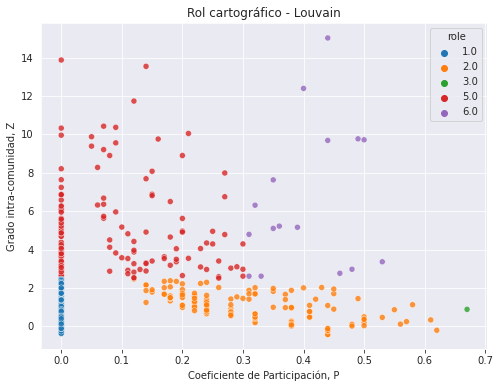

In [49]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)
ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")

ax.set_title("Rol cartográfico - Louvain")
# fig.savefig(reports_comunidades+"scatter_rol_cartografico_louvain.png",dpi=200)

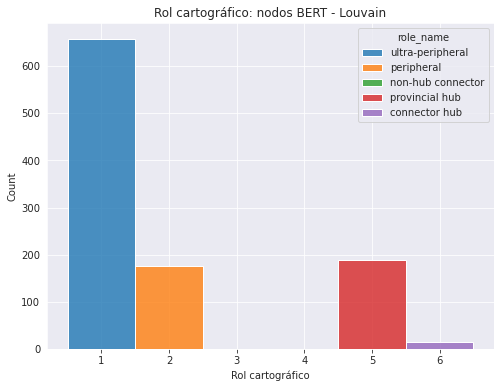

In [84]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos BERT - Louvain")
sns.histplot(data=bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain.png",dpi=200)

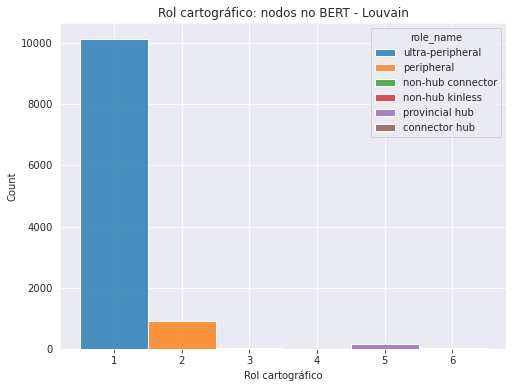

In [85]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos no BERT - Louvain")
sns.histplot(data=non_bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain_nonbert.png",dpi=200)